In [76]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier  
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [77]:
df = pd.read_csv(r"C:\Users\riyad\Documents\DS Projects\Lloyds_Data_Sci_internship_files\cleaned_df_v2.csv")

In [78]:
df.rename(columns={"TransactionDate":"TransactionFrequency"}, inplace=True)
df.drop(columns="LastLoginDate", inplace=True)
df

,CustomerID,Age,Gender,MaritalStatus,IncomeLevel,AmountSpent,TransactionFrequency,LoginFrequency,ServiceUsage,InteractionCount,ComplaintCount,FeedbackCount,InquiryCount,ResolvedCount,UnresolvedCount,ChurnStatus
0,1,62,M,Single,Low,416.50,1,34,Mobile App,1.0,0.0,0.0,1.0,1.0,0.0,0
1,2,65,M,Married,Low,1547.42,7,5,Website,1.0,0.0,0.0,1.0,1.0,0.0,1
2,3,18,M,Single,Low,1702.98,6,3,Website,1.0,0.0,0.0,1.0,1.0,0.0,0
3,4,21,M,Widowed,Low,917.29,5,2,Website,2.0,0.0,0.0,2.0,1.0,1.0,0
4,5,21,M,Divorced,Medium,2001.49,8,41,Website,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,54,F,Single,Low,227.25,1,38,Mobile App,0.0,0.0,0.0,0.0,0.0,0.0,0
996,997,19,M,Widowed,High,419.82,2,5,Mobile App,0.0,0.0,0.0,0.0,0.0,0.0,0
997,998,47,M,Married,Low,252.15,1,47,Website,0.0,0.0,0.0,0.0,0.0,0.0,0
998,999,23,M,Widowed,High,2393.26,9,23,Website,0.0,0.0,0.0,0.0,0.0,0.0,0


Last Login Date will cause issues as there is not much to convert it to as we do not have an account creation date. Also having login frequency reduces the need for Last Login Date

In [79]:
df.describe()

,CustomerID,Age,AmountSpent,TransactionFrequency,LoginFrequency,InteractionCount,ComplaintCount,FeedbackCount,InquiryCount,ResolvedCount,UnresolvedCount,ChurnStatus
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,43.267000,1267.074950,5.054000,25.912000,1.002000,0.335000,0.36000,0.307000,0.523000,0.479000,0.204000
std,288.819436,15.242311,738.590013,2.603433,14.055953,0.816494,0.546877,0.58029,0.518671,0.632353,0.621245,0.403171
min,1.000000,18.000000,9.800000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,250.750000,30.000000,626.685000,3.000000,13.750000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,500.500000,43.000000,1232.880000,5.000000,27.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,750.250000,56.000000,1791.902500,7.000000,38.000000,2.000000,1.000000,1.00000,1.000000,1.000000,1.000000,0.000000
max,1000.000000,69.000000,3386.040000,9.000000,49.000000,2.000000,2.000000,2.00000,2.000000,2.000000,2.000000,1.000000


### Additional Data Checks
Before scaling the numerical columns, i want to deep dive into the statistics of "Age" & "AmountSpent" to check normality

In [80]:
import scipy.stats as stats 

#create function to automate the check and test for normality of columns
def normal_displot_test(data, columns):
    """
    Normalizes specified columns and plots histograms and Q-Q plots to check for normality.

    Parameters:
    - data (pd.DataFrame): The input DataFrame containing the data.
    - columns (list): List of column names to normalize and plot.

    Returns:
    - data (pd.DataFrame): DataFrame with new columns for normalized values.
    """
    scaler = StandardScaler() 
    
    for feature in columns:
        # Normalise Data
        normalised_column = f"{feature}_scaled"
        data[normalised_column] = scaler.fit_transform(data[[feature]])
        
        # Plot Histogram with kde
        plt.figure(figsize=(10,5))
        sns.histplot(data[normalised_column], kde=True)
        plt.title(f"Distribution of {feature}")
        plt.xlabel("Standardised Value")
        plt.ylabel("Frequency")
        plt.show()
        
        #Q-Q Plot to test Guassian Distribution
        plt.figure(figsize=(10,5))
        stats.probplot(data[normalised_column], dist="norm", plot=plt)
        plt.title(f"Q-Q Plot for {feature}")
        plt.show()
    
    return data 

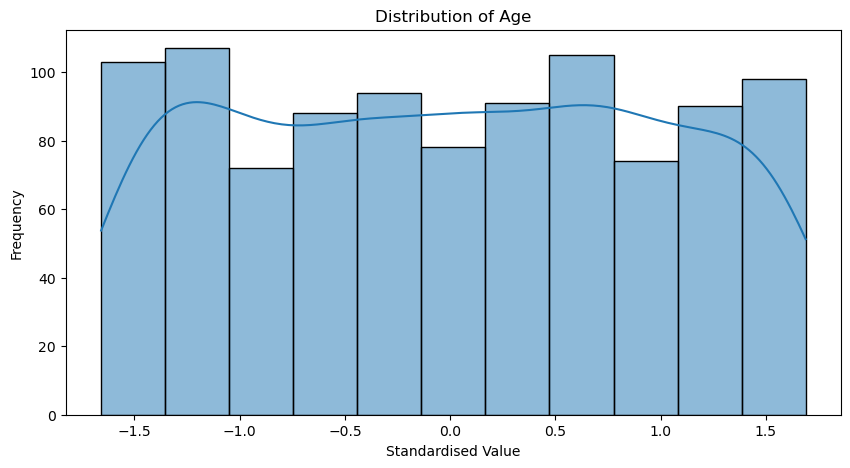

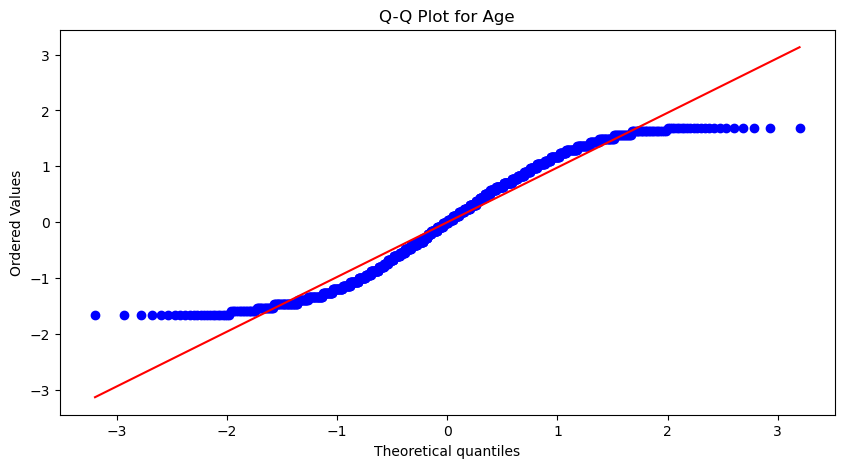

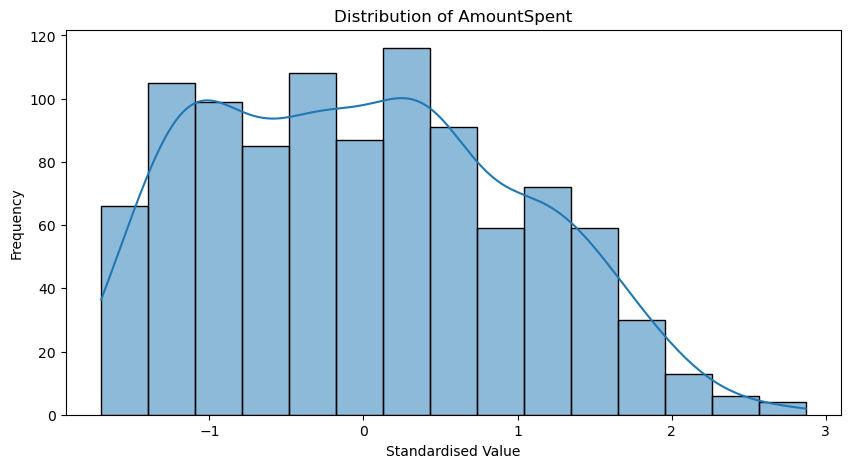

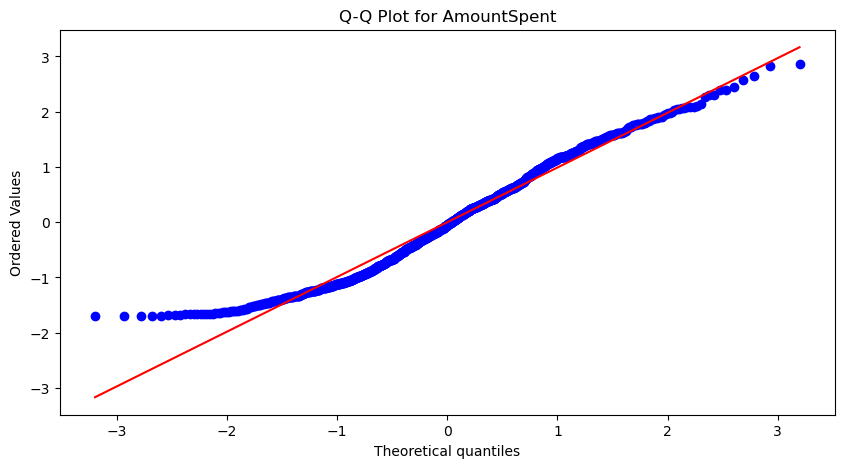

In [81]:
data = df.copy()
#columns = ["Age", "AmountSpent"]
normalised_features = normal_displot_test(data,["Age", "AmountSpent"])

#### Summary of Findings
##### Age:

* Histogram: Appears normally distributed, supporting the idea that the majority of values cluster around the mean, with fewer extreme values.
* Q-Q Plot: While it follows a straight line overall, the slight curves at the ends could indicate the presence of tails that are not extreme enough to be classified as outliers.

##### Amount Spent:

* Histogram: Shows some skewness, suggesting that while it is mostly normal, it might have some influence from lower values.
* Q-Q Plot: Indicates a close fit to a normal distribution with a slight curve away at both ends. The range from approximately -1.8 to 2.8 suggests that there may be some extreme values affecting the distribution.

1) **For Age:**

Use as-is: Since it appears normally distributed and shows no outliers,  can model without transformations. It should meet the assumptions of many statistical tests and models (like linear regression).
Feature Engineering: consider creating age bins possibly

2) **For Amount Spent:**

Further Investigation: If the histogram suggests skewness, consider further analysis to understand the nature of this skew. Consider applying transformations (like log transformation) to stabilise variance and make the distribution more normal.


In [82]:
df

,CustomerID,Age,Gender,MaritalStatus,IncomeLevel,AmountSpent,TransactionFrequency,LoginFrequency,ServiceUsage,InteractionCount,ComplaintCount,FeedbackCount,InquiryCount,ResolvedCount,UnresolvedCount,ChurnStatus
0,1,62,M,Single,Low,416.50,1,34,Mobile App,1.0,0.0,0.0,1.0,1.0,0.0,0
1,2,65,M,Married,Low,1547.42,7,5,Website,1.0,0.0,0.0,1.0,1.0,0.0,1
2,3,18,M,Single,Low,1702.98,6,3,Website,1.0,0.0,0.0,1.0,1.0,0.0,0
3,4,21,M,Widowed,Low,917.29,5,2,Website,2.0,0.0,0.0,2.0,1.0,1.0,0
4,5,21,M,Divorced,Medium,2001.49,8,41,Website,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,54,F,Single,Low,227.25,1,38,Mobile App,0.0,0.0,0.0,0.0,0.0,0.0,0
996,997,19,M,Widowed,High,419.82,2,5,Mobile App,0.0,0.0,0.0,0.0,0.0,0.0,0
997,998,47,M,Married,Low,252.15,1,47,Website,0.0,0.0,0.0,0.0,0.0,0.0,0
998,999,23,M,Widowed,High,2393.26,9,23,Website,0.0,0.0,0.0,0.0,0.0,0.0,0


# Encoding

OneHotEncoder will be categorical variables such as Gender, MaritalStatus, ServiceUsage. 
Ordinal Encodoing will be used for Income as it it has high 

In [83]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define Categorical Data
categorical_features_ohe = ["Gender", "MaritalStatus", "ServiceUsage"]
categorical_features_ode = ["IncomeLevel"]
income_level = [["Low", "Medium", "High"]]

#Define Numerical Data
numerical_features_ss = ["Age", "AmountSpent", "LoginFrequency", "TransactionFrequency"] 
# numerical_features_mm = ["InteractionCount", "ComplaintCount", "FeedbackCount",	"InquiryCount",	"ResolvedCount", "UnresolvedCount"] ignore as values are specific at 0,1,2


# set encoders
ohe =  OneHotEncoder(handle_unknown="ignore", sparse_output=False)
ode = OrdinalEncoder(categories=income_level)
log_transformer = FunctionTransformer(np.log1p)

# Preprocessor 
preprocessor = ColumnTransformer(transformers=[
    ("onehot",ohe,categorical_features_ohe),
    ("ordinal", ode,categorical_features_ode),
    ("standard", StandardScaler(), numerical_features_ss),
    ("log", log_transformer, ["AmountSpent"])
])

# Pipeline
pipeline = Pipeline(steps = [("preprocessor",preprocessor)])



# Split Data into Train & Test
Above is the cleaned data, it will be then split into train and test data then shall be encoded
* Target variable = Churn Status

In [84]:
from sklearn.model_selection import train_test_split
X = df.drop(columns="ChurnStatus")
y = df["ChurnStatus"]

# Split into train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 42)

# fit pipeline
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

smote =SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


Logistic Regression - Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.60      0.68       150
           1       0.29      0.50      0.37        50

    accuracy                           0.57       200
   macro avg       0.54      0.55      0.52       200
weighted avg       0.66      0.57      0.60       200


Decision Tree - Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.80      0.79       150
           1       0.36      0.34      0.35        50

    accuracy                           0.69       200
   macro avg       0.57      0.57      0.57       200
weighted avg       0.68      0.69      0.68       200


Random Forest - Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.94      0.85       150
           1       0.47      0.16      0.24        50

    accuracy                           0.74       200

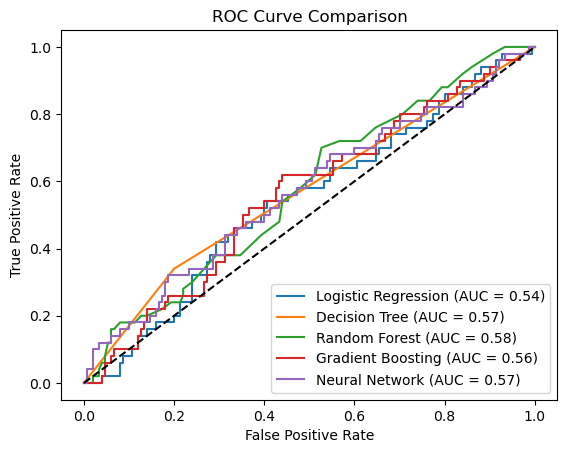


Model Performance Comparison:
                  Model  Accuracy  Precision  Recall  F1 Score   ROC AUC
0  Logistic Regression     0.575   0.294118    0.50  0.370370  0.542267
1        Decision Tree     0.685   0.361702    0.34  0.350515  0.570000
2        Random Forest     0.745   0.470588    0.16  0.238806  0.575733
3    Gradient Boosting     0.720   0.312500    0.10  0.151515  0.560133
4       Neural Network     0.680   0.325000    0.26  0.288889  0.567733


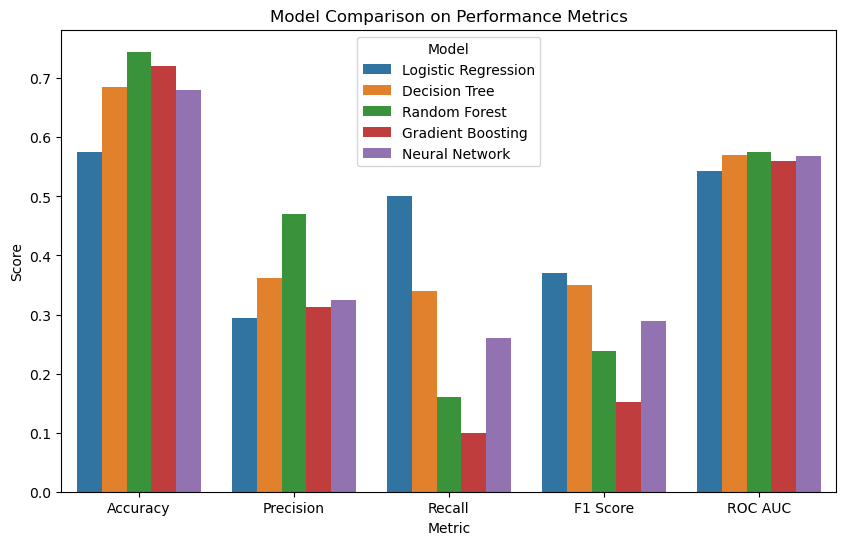

In [85]:
# Required Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Define models with basic parameter setups
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Neural Network": MLPClassifier(max_iter=500, random_state=42)
}

# Set up storage for model metrics
results = []

# Train, predict, and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    
    # Append results for comparison
    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC AUC": roc_auc
    })
    
    # Print classification report
    print(f"\n{model_name} - Classification Report:\n", classification_report(y_test, y_pred))
    
    # Plot ROC curve if probabilities are available
    if y_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

# Display ROC curve
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="best")
plt.show()

# Display model performance comparison
results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:\n", results_df)

# Visualize model metrics for comparison
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df.melt(id_vars="Model", value_vars=["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]), x="variable", y="value", hue="Model")
plt.title("Model Comparison on Performance Metrics")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.legend(title="Model")
plt.show()


In [87]:
gc.collect()

24584

In [88]:
# Example of GridSearchCV for Random Forest
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring="f1")
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)


Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best F1 score: 0.862642211972385


              precision    recall  f1-score   support

           0       0.76      0.95      0.84       150
           1       0.38      0.10      0.16        50

    accuracy                           0.73       200
   macro avg       0.57      0.52      0.50       200
weighted avg       0.67      0.73      0.67       200



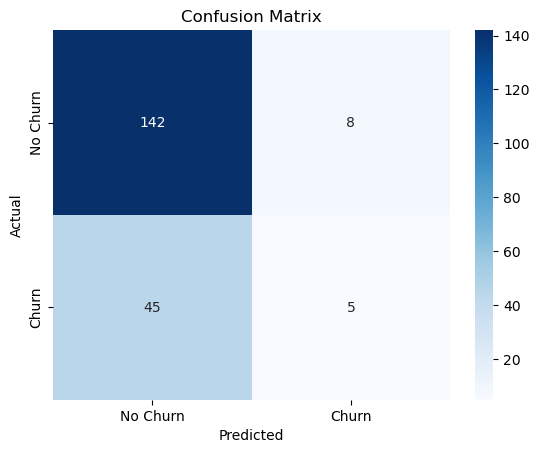

In [89]:
# Get the best model
best_model = grid_search.best_estimator_

# Fit on the entire training set (this step is usually done already in GridSearchCV)
best_model.fit(X_train, y_train)

# Predictions
y_pred = best_model.predict(X_test)

# Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix")
plt.show()


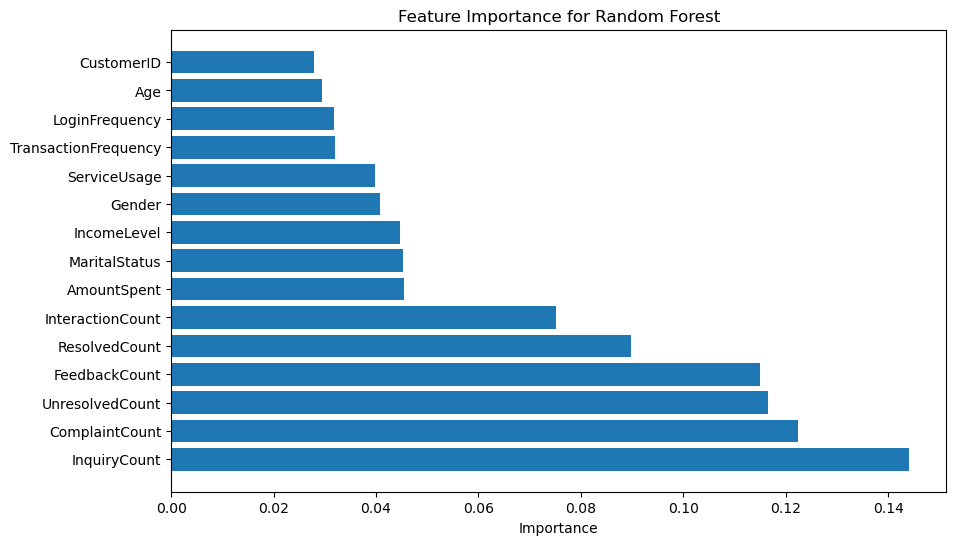

In [90]:
import pandas as pd
import matplotlib.pyplot as plt

feature_importances = best_model.feature_importances_
feature_names = X.columns  # Assuming X is your feature DataFrame

feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"])
plt.xlabel("Importance")
plt.title("Feature Importance for Random Forest")
plt.show()



Utilising the Model to Identify At-Risk Customers
Identify High-Risk Segments:

Use the model to score your entire customer base. Identify customers with high predicted probabilities of churn and prioritise them for targeted interventions.
Create segments based on churn risk scores to tailor retention strategies to different customer profiles (e.g., high-value customers vs. low-value customers).
Personalised Retention Strategies:

Develop targeted marketing campaigns for at-risk customers. This could include:
Special Offers: Discounts, loyalty rewards, or exclusive offers to incentivise continued engagement.
Tailored Communication: Personalised emails or messages that address specific needs or concerns of at-risk customers based on their interactions or complaints.
Customer Feedback Mechanisms: Encourage feedback from high-risk customers to understand their concerns and improve their experience.
Monitor Engagement Metrics:

Implement monitoring systems to track customer interactions post-intervention. Measure the effectiveness of retention strategies by analyzing changes in churn rates among targeted segments.
Create a Customer Journey Map:

Use insights from the model to visualise the customer journey and identify critical touchpoints that lead to churn. Focus on improving the customer experience at these touchpoints.
Integration with CRM Systems:

Integrate the model into Customer Relationship Management (CRM) systems to automate the identification of at-risk customers and trigger automated retention actions.
Potential Improvements to the Model
Feature Engineering:

Additional Features: Explore adding new features that might capture customer behavior better (e.g., time since last purchase, customer service interactions, or product usage patterns).
Temporal Features: Incorporate time-related features, such as tenure, seasonality, and changes over time, to account for temporal patterns in churn behavior.
Hyperparameter Tuning:

Continue to experiment with hyperparameter tuning using different ranges and more advanced search methods (like RandomisedSearchCV) to refine model performance further.
Advanced Modeling Techniques:

Ensemble Methods: Consider combining multiple models (e.g., stacking or blending) to leverage the strengths of different algorithms, which can lead to improved predictive performance.
Neural Networks: Explore deep learning models if you have a sufficiently large dataset, which can capture complex relationships in the data.
Time-Series Analysis: If applicable, consider modeling churn as a time-series problem to capture trends over time, especially for subscription-based services.
Cross-Validation:

Implement k-fold cross-validation during model training to ensure the model's generalisability and robustness across different subsets of data.
Regular Updates:

Continuously update the model with new data to capture evolving customer behaviors and refine predictions over time. This could involve retraining the model on a regular basis (e.g., monthly or quarterly).
Address Class Imbalance:

Further investigate methods for handling class imbalance if it persists, such as:
Alternative Resampling Techniques: Experiment with undersampling or more advanced synthetic sampling methods.
Cost-sensitive Learning: Modify the algorithm to take into account the cost of misclassifying the minority class, making the model more sensitive to churn predictions.
Business Recommendations
Decision Support System:

Develop dashboards that visualise churn predictions alongside relevant metrics (e.g., customer lifetime value, satisfaction scores) to assist management in decision-making.
Training and Development:

Provide training for marketing and customer support teams on how to leverage churn predictions in their strategies and interactions with customers.
Feedback Loop:

Establish a feedback loop where the outcomes of retention strategies are fed back into the model to improve its accuracy and relevance continuously.
A/B Testing:

Implement A/B testing for different retention strategies to determine the most effective approaches based on model predictions.
Customer Education:

Educate at-risk customers on the value of your service, features they may not be utilising, or community aspects that might enhance their engagement and loyalty.
